In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np
import os
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

## Prepare the data

In [2]:
path = r"C:\Users\Diego\GenX\GenX.jl-main\test_systems\1_three_zones\TDR_results_HO"

In [3]:
p_demand = "Demand_data.csv"
p_fuel = "Fuels_data.csv"
p_CF = "Generators_variability.csv"

path_demand = os.path.join(path, p_demand)
path_fuel = os.path.join(path, p_fuel)
path_CF = os.path.join(path, p_CF)

df_demand = pd.read_csv(path_demand)
df_fuel = pd.read_csv(path_fuel)
df_CF = pd.read_csv(path_CF)

In [4]:
zones_name = ["ME", "MA", "CT"]
zones_numbers = ["z1", "z2", "z3"]
df_tot = pd.DataFrame()

for i in range (len(zones_name)):
    df_name = "df_" + zones_name[i]
    df_Z1 = df_demand.loc[:,list(df_demand.filter(like=zones_numbers[i]).columns)]
    df_f_z= df_fuel.loc[1:, df_fuel.filter(like=zones_name[i]).columns].reset_index(drop=True)
    df_tot = pd.concat([df_tot, df_Z1, df_CF.loc[:, df_CF.columns.str.startswith(zones_name[i])], df_f_z], axis=1)

df_tot['Time_Index'] = df_tot.index +1 

In [5]:
df_tot.columns

Index(['Demand_MW_z1', 'ME_natural_gas_combined_cycle', 'ME_onshore_wind',
       'ME_battery', 'ME_NG', 'Demand_MW_z2', 'MA_natural_gas_combined_cycle',
       'MA_solar_pv', 'MA_battery', 'MA_NG', 'Demand_MW_z3',
       'CT_natural_gas_combined_cycle', 'CT_onshore_wind', 'CT_solar_pv',
       'CT_battery', 'CT_NG', 'Time_Index'],
      dtype='object')

In [6]:
df_tot

,Demand_MW_z1,ME_natural_gas_combined_cycle,ME_onshore_wind,ME_battery,ME_NG,Demand_MW_z2,MA_natural_gas_combined_cycle,MA_solar_pv,MA_battery,MA_NG,Demand_MW_z3,CT_natural_gas_combined_cycle,CT_onshore_wind,CT_solar_pv,CT_battery,CT_NG,Time_Index
0,8761.0,1.0,0.651881,1.0,5.45,2502.0,1.0,0.0,1.0,5.28,1195.0,1.0,0.654001,0.0,1.0,5.45,1
1,8474.0,1.0,0.662853,1.0,5.45,2420.0,1.0,0.0,1.0,5.28,1156.0,1.0,0.640632,0.0,1.0,5.45,2
2,8336.0,1.0,0.688196,1.0,5.45,2380.0,1.0,0.0,1.0,5.28,1136.0,1.0,0.674217,0.0,1.0,5.45,3
3,8275.0,1.0,0.530140,1.0,5.45,2364.0,1.0,0.0,1.0,5.28,1128.0,1.0,0.591154,0.0,1.0,5.45,4
4,8330.0,1.0,0.557922,1.0,5.45,2379.0,1.0,0.0,1.0,5.28,1136.0,1.0,0.498415,0.0,1.0,5.45,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,11306.0,1.0,0.686734,1.0,3.78,3229.0,1.0,0.0,1.0,4.28,1541.0,1.0,0.469633,0.0,1.0,3.78,1844
1844,10825.0,1.0,0.489719,1.0,3.78,3091.0,1.0,0.0,1.0,4.28,1476.0,1.0,0.907785,0.0,1.0,3.78,1845
1845,10825.0,1.0,0.489719,1.0,3.78,3091.0,1.0,0.0,1.0,4.28,1476.0,1.0,0.907785,0.0,1.0,3.78,1846
1846,9579.0,1.0,0.338084,1.0,3.78,2735.0,1.0,0.0,1.0,4.28,1306.0,1.0,0.612955,0.0,1.0,3.78,1847


# DBSCAN 

c:\Users\Diego\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Diego\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


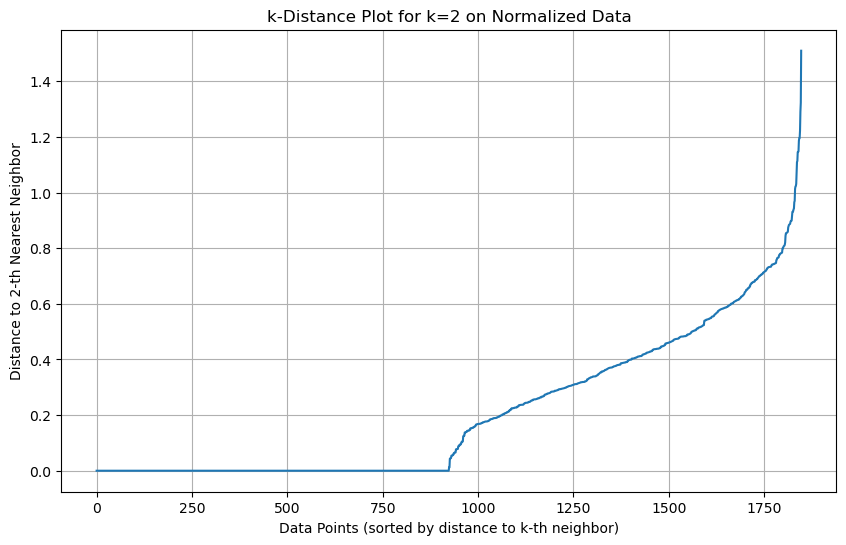

In [7]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Set the number of neighbors (k) for the k-distance plot
k = 2  # Often 4 or 5 for DBSCAN epsilon estimation but we are not clustering but rather looking for similar hours that are densily packed together

# Normalize the data (df_tot_normalized) if not already normalized
scaler = StandardScaler()
df_tot_normalized = scaler.fit_transform(df_tot.drop(columns=['Time_Index']))

# Fit the NearestNeighbors model to the normalized data
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(df_tot_normalized)

# Compute the distances to the k-th nearest neighbor for each point
distances, _ = neigh.kneighbors(df_tot_normalized)

# Sort distances to find the "elbow" in the k-distance plot
k_distances = np.sort(distances[:, k - 1])

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title(f'k-Distance Plot for k={k} on Normalized Data')
plt.xlabel('Data Points (sorted by distance to k-th neighbor)')
plt.ylabel(f'Distance to {k}-th Nearest Neighbor')
plt.grid(True)
plt.show()

## DBSCAN: for an epsilon values of 0.05

In [8]:
# Step 1: Normalize
scaler = StandardScaler()
df_tot_normalized = scaler.fit_transform(df_tot.drop(columns=['Time_Index']))

#Step 2: apply DBSCAN 
dbscan = DBSCAN(eps=0.05, min_samples=2)  # Adjust eps as needed
labels = dbscan.fit_predict(df_tot_normalized)
df_tot['Cluster'] = labels

c:\Users\Diego\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Diego\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Diego\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Diego\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

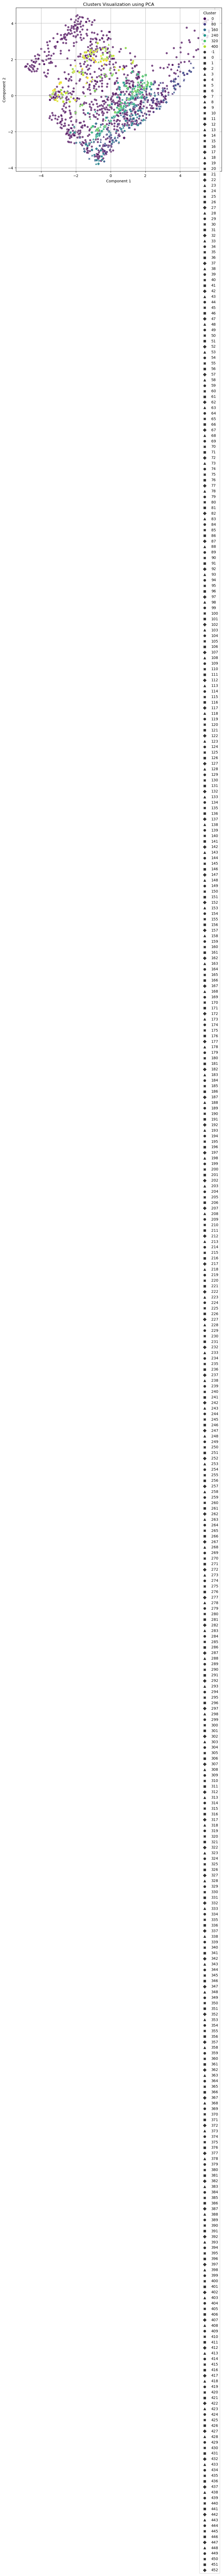

In [9]:
# Step 3: PCA or t-SNE for visualization
# Choose PCA or t-SNE
use_pca = True  # Set to False if you want to use t-SNE instead

if use_pca:
    pca = PCA(n_components=2)
    components = pca.fit_transform(df_tot_normalized)
else:
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    components = tsne.fit_transform(df_tot_normalized)

# Step 4: Create a DataFrame for the components
df_plot = pd.DataFrame(data=components, columns=['Component 1', 'Component 2'])
df_plot['Cluster'] = labels

# Step 5: Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_plot, x='Component 1', y='Component 2', hue='Cluster', palette='viridis', style='Cluster', markers=['o', 'X', 's', 'D', '^'], alpha=0.7)
plt.title('Clusters Visualization using PCA' if use_pca else 'Clusters Visualization using t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [10]:
labels[labels != -1]

array([  0,   0,   1,   1,   2,   2,   3,   3,   4,   4,   5,   5,   6,
         6,   7,   7,   8,   8,   9,   9,  10,  10,  11,  11,  12,  12,
        13,  13,  14,  14,  15,  15,  16,  16,  17,  17,  18,  18,  19,
        19,  20,  20,  21,  21,  22,  22,  23,  23,  24,  24,  25,  25,
        26,  26,  27,  27,  28,  28,  29,  29,  30,  30,  31,  31,  32,
        32,  33,  33,  34,  34,  35,  35,  36,  36,  37,  37,  38,  38,
        39,  39,  40,  40,  41,  41,  42,  42,  43,  43,  44,  44,  45,
        45,  46,  46,  47,  47,  48,  48,  49,  49,  50,  50,  51,  51,
        52,  52,  53,  53,  54,  54,  55,  55,  56,  56,  57,  57,  58,
        58,  59,  59,  60,  60,  61,  61,  62,  62,  63,  63,  64,  64,
        65,  65,  66,  66,  67,  67,  68,  68,  69,  69,  70,  70,  71,
        71,  72,  72,  73,  73,  74,  74,  75,  75,  76,  76,  77,  77,
        78,  78,  79,  79,  80,  80,  81,  81,  82,  82,  83,  83,  84,
        84,  85,  85,  86,  86,  87,  87,  88,  88,  89,  89,  9

In [11]:
# Step 4: Identify Consecutive Hours in the Same Cluster
consecutive_hours_dfs = []
for label in set(labels):
    if label != -1:  # Ignore noise points (-1)
        group = df_tot[df_tot['Cluster'] == label]
        consecutive_indices = []  # To keep track of consecutive hour indices

        # Loop through the group to find consecutive hours
        for i in range(len(group) - 1):
            # Check if the current hour and the next hour are consecutive
            if group['Time_Index'].iloc[i] + 1 == group['Time_Index'].iloc[i + 1]:
                consecutive_indices.append(group.index[i])  # Append the current index

                # If it's the last index in the group, append the last hour
                if i == len(group) - 2:
                    consecutive_indices.append(group.index[i + 1])

            else:
                # If we find a break in consecutiveness, check if we have consecutive indices to save
                if len(consecutive_indices) > 0:
                    # Append the DataFrame of consecutive hours to the list
                    consecutive_hours_dfs.append(group.loc[consecutive_indices])
                    consecutive_indices = []  # Reset for the next sequence

        # Handle case for any remaining consecutive hours at the end of the group
        if len(consecutive_indices) > 0:
            consecutive_hours_dfs.append(group.loc[consecutive_indices])

# Concatenate all the DataFrames in the list into a single DataFrame
consecutive_hours_df = pd.concat(consecutive_hours_dfs, ignore_index=True)
consecutive_hours_df.reset_index(drop=True, inplace=True)
consecutive_hours_df

,Demand_MW_z1,ME_natural_gas_combined_cycle,ME_onshore_wind,ME_battery,ME_NG,Demand_MW_z2,MA_natural_gas_combined_cycle,MA_solar_pv,MA_battery,MA_NG,Demand_MW_z3,CT_natural_gas_combined_cycle,CT_onshore_wind,CT_solar_pv,CT_battery,CT_NG,Time_Index,Cluster
0,11072.0,1.0,0.776980,1.0,4.09,3162.0,1.0,0.0000,1.0,3.98,1509.0,1.0,0.812564,0.0000,1.0,4.09,306,0
1,11096.0,1.0,0.765658,1.0,4.09,3169.0,1.0,0.0000,1.0,3.98,1513.0,1.0,0.808292,0.0000,1.0,4.09,307,0
2,6596.0,1.0,0.371058,1.0,2.13,1883.0,1.0,0.0000,1.0,3.18,899.0,1.0,0.720491,0.0000,1.0,2.13,603,1
3,6596.0,1.0,0.368630,1.0,2.13,1884.0,1.0,0.0000,1.0,3.18,899.0,1.0,0.723647,0.0000,1.0,2.13,604,1
4,12425.0,1.0,0.437235,1.0,1.89,3549.0,1.0,0.5773,1.0,2.34,1694.0,1.0,0.011530,0.5645,1.0,1.89,925,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,11306.0,1.0,0.686734,1.0,3.78,3229.0,1.0,0.0000,1.0,4.28,1541.0,1.0,0.469633,0.0000,1.0,3.78,1844,450
913,10825.0,1.0,0.489719,1.0,3.78,3091.0,1.0,0.0000,1.0,4.28,1476.0,1.0,0.907785,0.0000,1.0,3.78,1845,451
914,10825.0,1.0,0.489719,1.0,3.78,3091.0,1.0,0.0000,1.0,4.28,1476.0,1.0,0.907785,0.0000,1.0,3.78,1846,451
915,9579.0,1.0,0.338084,1.0,3.78,2735.0,1.0,0.0000,1.0,4.28,1306.0,1.0,0.612955,0.0000,1.0,3.78,1847,452


## DBSCAN: with several epsilons

In [12]:
zones_name = ["ME", "MA", "CT"]
zones_numbers = ["z1", "z2", "z3"]
df_tot = pd.DataFrame()

for i in range (len(zones_name)):
    df_name = "df_" + zones_name[i]
    df_Z1 = df_demand.loc[:,list(df_demand.filter(like=zones_numbers[i]).columns)]
    df_f_z= df_fuel.loc[1:, df_fuel.filter(like=zones_name[i]).columns].reset_index(drop=True)
    df_tot = pd.concat([df_tot, df_Z1, df_CF.loc[:, df_CF.columns.str.startswith(zones_name[i])], df_f_z], axis=1)

df_tot['Time_Index'] = df_tot.index +1 

c:\Users\Diego\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Diego\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


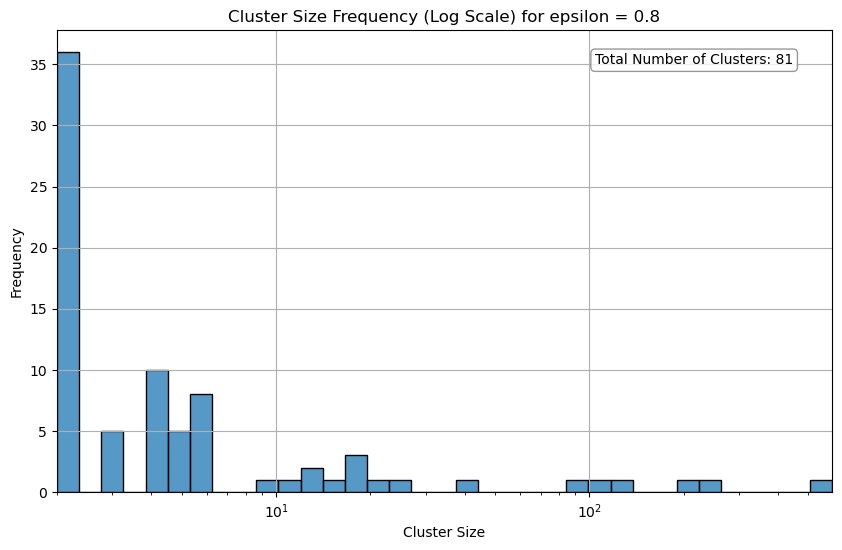

c:\Users\Diego\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Diego\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Diego\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: autodetected range of [-inf, -0.41989811324243237] is not finite

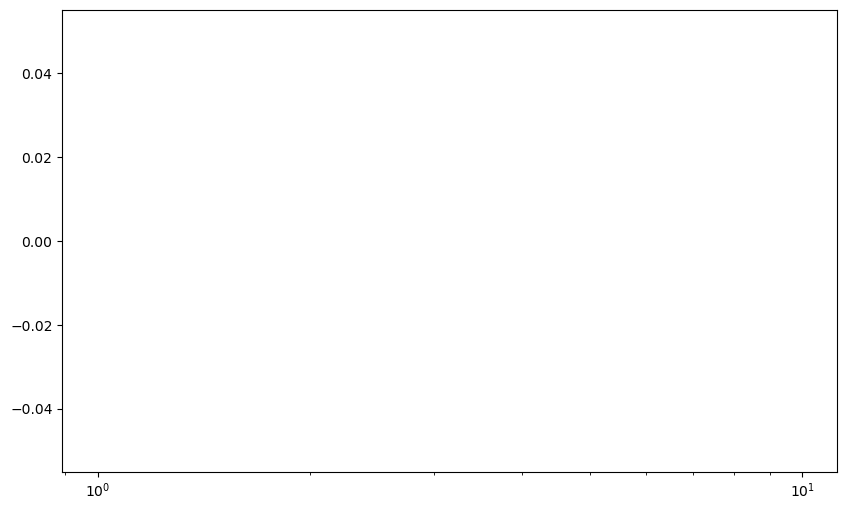

In [13]:
# Normalize the data excluding the 'Time_Index' column
scaler = StandardScaler()
df_tot_normalized = scaler.fit_transform(df_tot.drop(columns=['Time_Index']))
df_tot_normalized_df = pd.DataFrame(df_tot_normalized, columns=df_tot.columns.drop('Time_Index'))
df_tot_norm_w_tindex = pd.concat([df_tot[['Time_Index']].reset_index(drop=True), df_tot_normalized_df], axis=1)

# Initialize list to store results for each epsilon
epsilon_results = []

# Epsilon values to test
epsilon_values = [0.8, 0.4, 0.3, 0.2, 0.1]
df_tot_eps = {}

# First pass to find global axis limits for the x-axes
all_cluster_sizes = []
all_cluster_variances = []

for eps in epsilon_values:
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=2)
    labels = dbscan.fit_predict(df_tot_normalized)
    
    # Create a DataFrame to store clustering results for this epsilon
    df_epsilon = df_tot_normalized_df.copy()  # Exclude Time_Index for variance calculation
    df_epsilon['Cluster'] = labels
    df_tot['Cluster'] = labels
    df_tot_eps[eps] = df_tot.copy()
    df_tot.drop(columns=['Cluster'], inplace=True)
    
    # Filter out outlier cluster (-1)
    clusters = df_epsilon[df_epsilon['Cluster'] != -1]['Cluster']
    
    # Collect cluster sizes and variance within each cluster
    cluster_sizes = clusters.value_counts()
    cluster_variances = df_epsilon[df_epsilon['Cluster'] != -1].groupby('Cluster').var().mean(axis=1)
    
    all_cluster_sizes.extend(cluster_sizes)
    all_cluster_variances.extend(cluster_variances)
    
    # Plot Cluster Size Frequency
    plt.figure(figsize=(10, 6))
    sns.histplot(cluster_sizes, kde=False, bins=35, log_scale=(True, False))
    plt.title(f'Cluster Size Frequency (Log Scale) for epsilon = {eps}')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    plt.xlim(min(all_cluster_sizes), max(all_cluster_sizes))
    plt.grid(True)
    total_clusters = len(cluster_sizes)
    plt.text(
        0.95, 0.95,
        f'Total Number of Clusters: {total_clusters}',
        transform=plt.gca().transAxes,
        fontsize=10,
        color='black',
        ha='right',
        va='top',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.8)
    )
    plt.show()
    
    # Plot Cluster Variance Frequency
    plt.figure(figsize=(10, 6))
    sns.histplot(cluster_variances, kde=False, bins=35, log_scale=(True, False))
    plt.title(f'Avg. Variance within Clusters (Log Scale) for epsilon = {eps}')
    plt.xlabel('Cluster Avg. Variance')
    plt.ylabel('Frequency')
    plt.xlim(1e-5, 1e-0)
    plt.ylim(0, 50)
    plt.grid(True)
    total_clusters = len(cluster_sizes)
    plt.text(
        0.95, 0.95,
        f'Total Number of Clusters: {total_clusters}',
        transform=plt.gca().transAxes,
        fontsize=10,
        color='black',
        ha='right',
        va='top',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.8)
    )
    plt.show()
    
    # Store the results for each epsilon
    result = {
        'Epsilon': eps,
        'Num_Clusters': len(cluster_sizes),
        'Median_Cluster_Size': cluster_sizes.median()
    }
    epsilon_results.append(result)

# Create a DataFrame to display the summary results for each epsilon
epsilon_df = pd.DataFrame(epsilon_results)
print(epsilon_df)

In [ ]:
df_tot.head(4)

,Demand_MW_z1,ME_natural_gas_combined_cycle,ME_onshore_wind,ME_battery,ME_NG,Demand_MW_z2,MA_natural_gas_combined_cycle,MA_solar_pv,MA_battery,MA_NG,Demand_MW_z3,CT_natural_gas_combined_cycle,CT_onshore_wind,CT_solar_pv,CT_battery,CT_NG,Time_Index
0,7404.0,1.0,0.818971,1.0,5.45,2114.0,1.0,0.0,1.0,5.28,1010.0,1.0,0.997932,0.0,1.0,5.45,1
1,7089.0,1.0,0.724056,1.0,5.45,2024.0,1.0,0.0,1.0,5.28,966.0,1.0,0.982208,0.0,1.0,5.45,2
2,6902.0,1.0,0.717351,1.0,5.45,1971.0,1.0,0.0,1.0,5.28,941.0,1.0,0.986260,0.0,1.0,5.45,3
3,6852.0,1.0,0.723726,1.0,5.45,1957.0,1.0,0.0,1.0,5.28,934.0,1.0,0.994179,0.0,1.0,5.45,4


In [ ]:
df_tot_eps[0.2].head(4)

,Demand_MW_z1,ME_natural_gas_combined_cycle,ME_onshore_wind,ME_battery,ME_NG,Demand_MW_z2,MA_natural_gas_combined_cycle,MA_solar_pv,MA_battery,MA_NG,Demand_MW_z3,CT_natural_gas_combined_cycle,CT_onshore_wind,CT_solar_pv,CT_battery,CT_NG,Time_Index,Cluster
0,7404.0,1.0,0.818971,1.0,5.45,2114.0,1.0,0.0,1.0,5.28,1010.0,1.0,0.997932,0.0,1.0,5.45,1,0
1,7089.0,1.0,0.724056,1.0,5.45,2024.0,1.0,0.0,1.0,5.28,966.0,1.0,0.982208,0.0,1.0,5.45,2,1
2,6902.0,1.0,0.717351,1.0,5.45,1971.0,1.0,0.0,1.0,5.28,941.0,1.0,0.986260,0.0,1.0,5.45,3,1
3,6852.0,1.0,0.723726,1.0,5.45,1957.0,1.0,0.0,1.0,5.28,934.0,1.0,0.994179,0.0,1.0,5.45,4,1


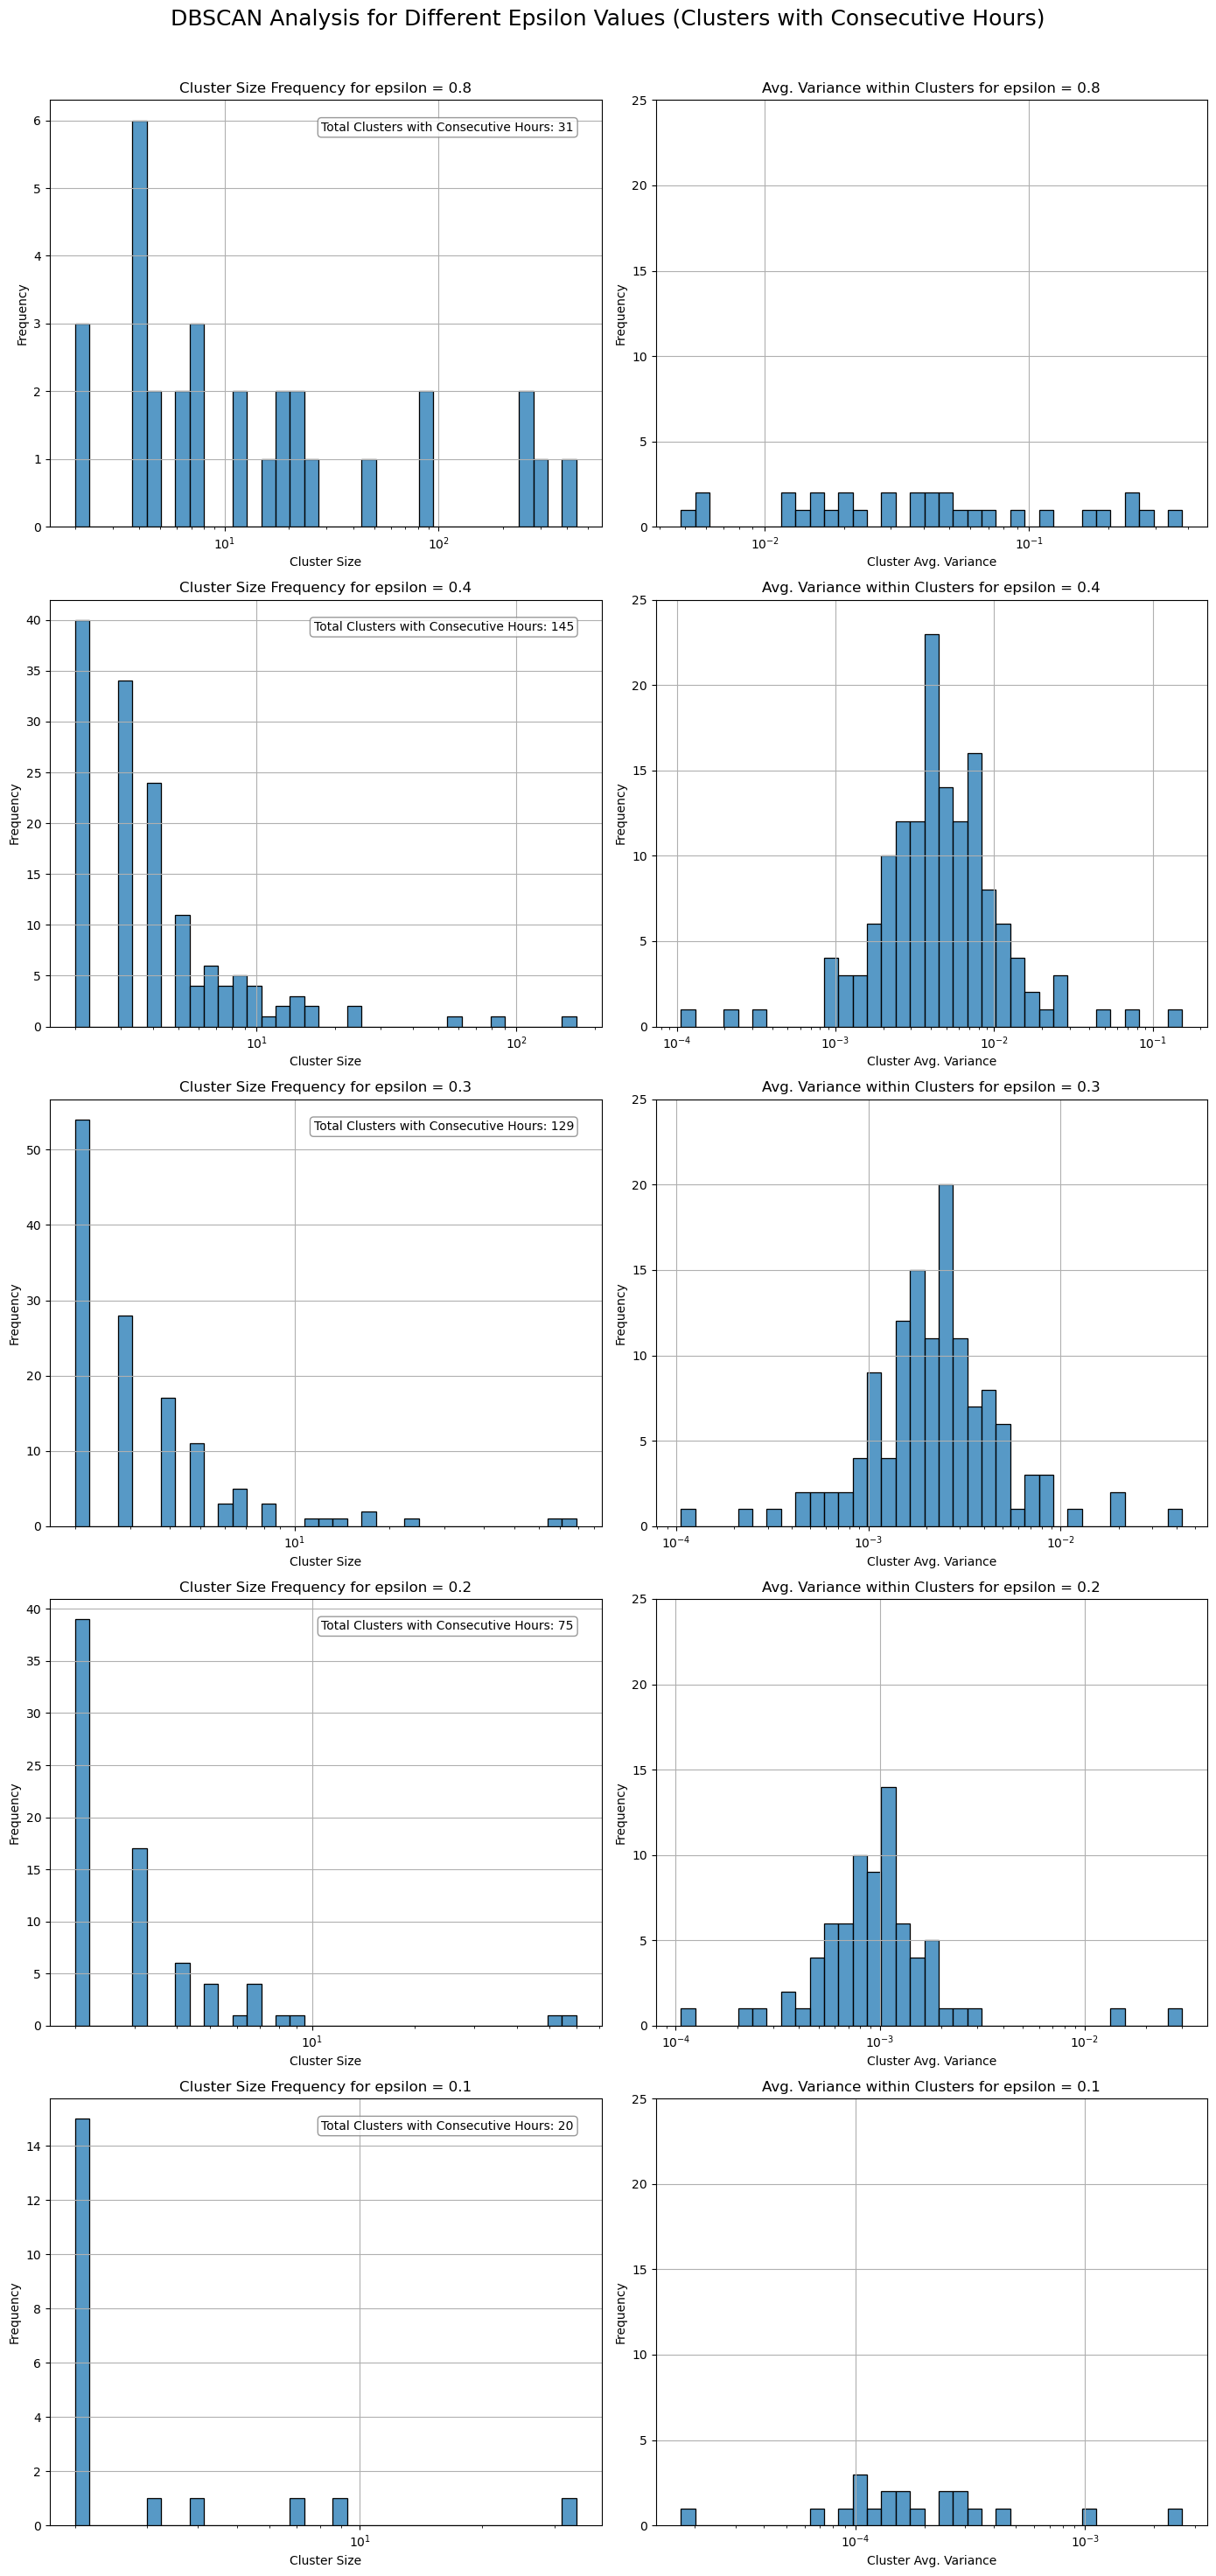

In [ ]:
"""
Plot Cluster size and Avg. Cluster Variance distribution 
- Using DBSCAN resulsy 
"""

# Normalize the data excluding the 'Time_Index' column
scaler = StandardScaler()
df_tot_normalized = scaler.fit_transform(df_tot.drop(columns=['Time_Index']))
df_tot_normalized_df = pd.DataFrame(df_tot_normalized, columns=df_tot.columns.drop('Time_Index'))
df_tot_norm_w_tindex = pd.concat([df_tot[['Time_Index']].reset_index(drop=True), df_tot_normalized_df], axis=1)

# Initialize list to store results and DataFrames for each epsilon
epsilon_results = []
consecutive_hours_dfs = {}

# Epsilon values to test
epsilon_values = [0.8, 0.4, 0.3, 0.2, 0.1]

# Prepare the figure with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(14, 30))
fig.suptitle('DBSCAN Analysis for Different Epsilon Values (Clusters with Consecutive Hours)', fontsize=18)

# Define a common y-axis limit for variance plots on the right
common_y_axis_limit = [0, 25]

for idx, eps in enumerate(epsilon_values):
    labels = df_tot_eps[eps]['Cluster']
    
    # Create a DataFrame to store clustering results for this epsilon
    df_epsilon = df_tot_normalized_df.copy()
    df_epsilon['Cluster'] = labels
    
    # Identify clusters with at least one consecutive pair of hours
    valid_clusters = []
    consecutive_rows = []
    for label in set(labels):
        if label != -1:
            cluster_group = df_tot_eps[eps][df_tot_eps[eps]['Cluster'] == label]
            consecutive_indices = []

            for i in range(len(cluster_group) - 1):
                if cluster_group['Time_Index'].iloc[i] + 1 == cluster_group['Time_Index'].iloc[i + 1]:
                    consecutive_indices.append(cluster_group.index[i])
                    if i == len(cluster_group) - 2:
                        consecutive_indices.append(cluster_group.index[i + 1])

            if consecutive_indices:
                valid_clusters.append(label)
                consecutive_rows.extend(consecutive_indices)

    df_consecutive = df_tot_eps[eps].loc[consecutive_rows].copy()
    consecutive_hours_dfs[eps] = df_consecutive

    filtered_df = df_epsilon[df_epsilon['Cluster'].isin(valid_clusters)]
    cluster_sizes = filtered_df['Cluster'].value_counts()
    cluster_variances = filtered_df.groupby('Cluster').var().mean(axis=1)

    # Plot Cluster Size Frequency
    sns.histplot(cluster_sizes, kde=False, bins=35, ax=axes[idx, 0], log_scale=(True, False))
    axes[idx, 0].set_title(f'Cluster Size Frequency for epsilon = {eps}', fontsize=12)
    axes[idx, 0].set_xlabel('Cluster Size')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True)
    total_clusters = len(cluster_sizes)
    axes[idx, 0].text(
        0.95, 0.95,
        f'Total Clusters with Consecutive Hours: {total_clusters}',
        transform=axes[idx, 0].transAxes,
        fontsize=10,
        color='black',
        ha='right',
        va='top',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.8)
    )

    # Plot Cluster Variance Frequency with a fixed y-axis limit
    sns.histplot(cluster_variances, kde=False, bins=35, ax=axes[idx, 1], log_scale=(True, False))
    axes[idx, 1].set_title(f'Avg. Variance within Clusters for epsilon = {eps}', fontsize=12)
    axes[idx, 1].set_xlabel('Cluster Avg. Variance')
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].set_ylim(common_y_axis_limit)  # Set the common y-axis limit here
    axes[idx, 1].grid(True)

    # Store the results for each epsilon
    result = {
        'Epsilon': eps,
        'Num_Clusters_With_Consecutive_Hours': len(cluster_sizes),
        'Mean_Cluster_Variance': cluster_variances.mean()
    }
    epsilon_results.append(result)

# Adjust layout and show the figure
plt.tight_layout(rect=[0, 0, 1, 0.97])


In [ ]:
consecutive_hours_dfs[eps]

,Demand_MW_z1,ME_natural_gas_combined_cycle,ME_onshore_wind,ME_battery,ME_NG,Demand_MW_z2,MA_natural_gas_combined_cycle,MA_solar_pv,MA_battery,MA_NG,Demand_MW_z3,CT_natural_gas_combined_cycle,CT_onshore_wind,CT_solar_pv,CT_battery,CT_NG,Time_Index,Cluster
2,6902.0,1.0,0.717351,1.0,5.45,1971.0,1.0,0.0,1.0,5.28,941.0,1.0,0.986260,0.0,1.0,5.45,3,0
3,6852.0,1.0,0.723726,1.0,5.45,1957.0,1.0,0.0,1.0,5.28,934.0,1.0,0.994179,0.0,1.0,5.45,4,0
4,6904.0,1.0,0.723625,1.0,5.45,1972.0,1.0,0.0,1.0,5.28,941.0,1.0,0.966725,0.0,1.0,5.45,5,0
146,7802.0,1.0,0.996925,1.0,5.45,2229.0,1.0,0.0,1.0,5.28,1064.0,1.0,0.998924,0.0,1.0,5.45,147,4
147,7742.0,1.0,0.980940,1.0,5.45,2211.0,1.0,0.0,1.0,5.28,1055.0,1.0,1.000000,0.0,1.0,5.45,148,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,12036.0,1.0,0.000105,1.0,2.78,3437.0,1.0,0.0,1.0,2.74,1641.0,1.0,0.000953,0.0,1.0,2.78,1555,33
1730,7066.0,1.0,0.824690,1.0,3.78,2018.0,1.0,0.0,1.0,4.28,963.0,1.0,0.998820,0.0,1.0,3.78,1731,38
1731,7064.0,1.0,0.809692,1.0,3.78,2018.0,1.0,0.0,1.0,4.28,963.0,1.0,0.988576,0.0,1.0,3.78,1732,38
1745,11925.0,1.0,0.826578,1.0,3.78,3406.0,1.0,0.0,1.0,4.28,1625.0,1.0,0.973172,0.0,1.0,3.78,1746,39


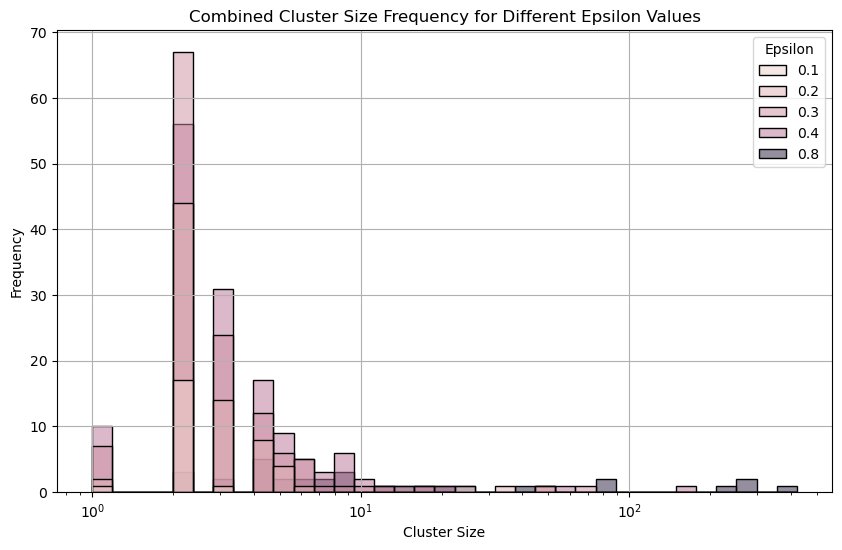

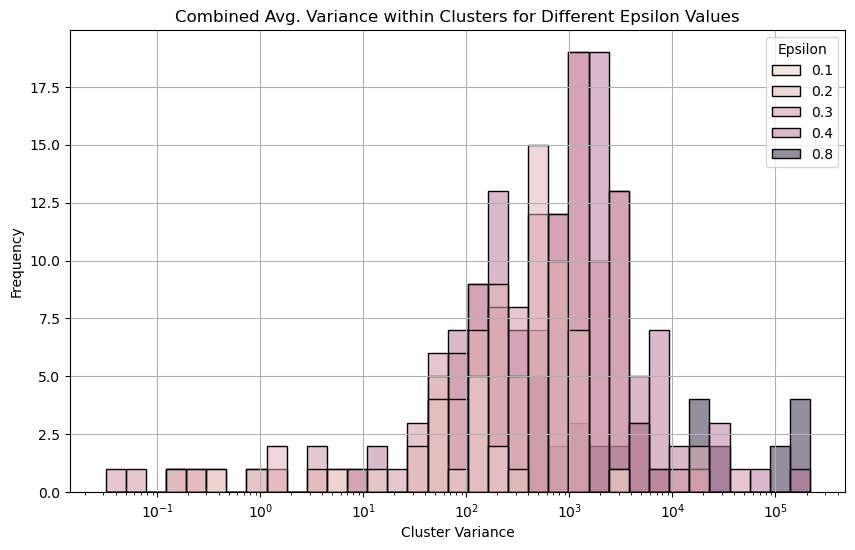

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize lists to store combined data for both epsilons
combined_cluster_sizes = []
combined_cluster_variances = []

# Populate combined lists with data from each epsilon
for eps in epsilon_values:
    cluster_sizes = consecutive_hours_dfs[eps]['Cluster'].value_counts()
    cluster_variances = consecutive_hours_dfs[eps].drop(columns=['Time_Index']).groupby('Cluster').var().mean(axis=1)
    
    # Append data with epsilon information
    combined_cluster_sizes.extend([(size, eps) for size in cluster_sizes])
    combined_cluster_variances.extend([(variance, eps) for variance in cluster_variances])

# Convert to DataFrames for plotting
df_cluster_sizes = pd.DataFrame(combined_cluster_sizes, columns=['Cluster Size', 'Epsilon'])
df_cluster_variances = pd.DataFrame(combined_cluster_variances, columns=['Cluster Variance', 'Epsilon'])

# Plot combined Cluster Size Frequency
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cluster_sizes, x='Cluster Size', hue='Epsilon', bins=35, log_scale=(True, False), kde=False)
plt.title('Combined Cluster Size Frequency for Different Epsilon Values')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot combined Cluster Variance Frequency
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cluster_variances, x='Cluster Variance', hue='Epsilon', bins=35, log_scale=(True, False), kde=False)
plt.title('Combined Avg. Variance within Clusters for Different Epsilon Values')
plt.xlabel('Cluster Variance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Correlaation between average cluster variance and cluster size

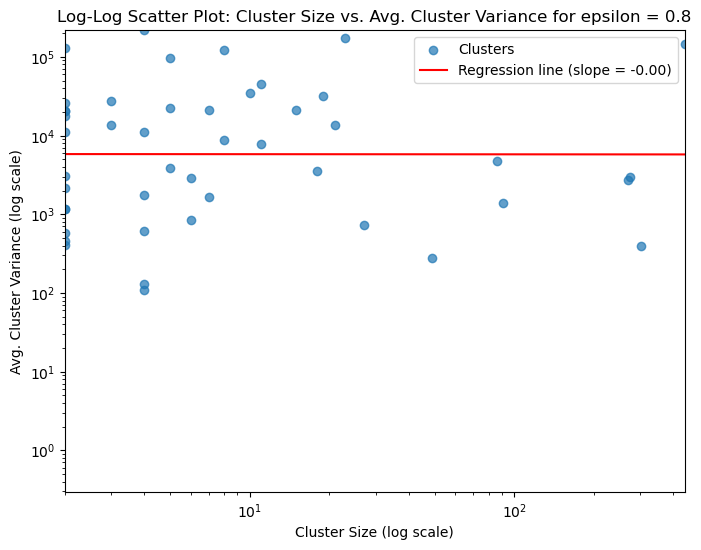

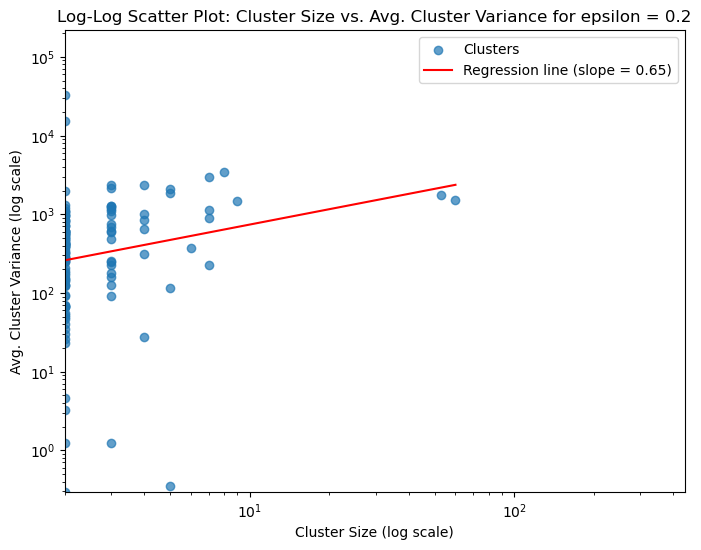

   Epsilon  Num_Clusters  Median_Cluster_Size
0      0.8            46                  5.0
1      0.2           131                  2.0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize the data excluding the 'Time_Index' column
scaler = StandardScaler()
df_tot_normalized = scaler.fit_transform(df_tot.drop(columns=['Time_Index']))

# Initialize list to store results for each epsilon
epsilon_results = []

# Epsilon values to test
epsilon_values = [0.8, 0.2]

# First pass to find global axis limits for the x-axes
all_cluster_sizes = []
all_cluster_variances = []

for eps in epsilon_values:
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=2)
    labels = dbscan.fit_predict(df_tot_normalized)
    df_tot['Cluster'] = labels
    
    # Filter out outlier cluster (-1)
    clusters = df_tot[df_tot['Cluster'] != -1]['Cluster']
    
    # Collect cluster sizes and variance within each cluster
    cluster_sizes = clusters.value_counts()
    cluster_variances = df_tot[df_tot['Cluster'] != -1].groupby('Cluster').var().mean(axis=1)
    
    all_cluster_sizes.extend(cluster_sizes)
    all_cluster_variances.extend(cluster_variances)

# Define global x-axis limits based on the collected data
x_lim_cluster_size = (min(all_cluster_sizes), max(all_cluster_sizes))
x_lim_cluster_variance = (min(all_cluster_variances), max(all_cluster_variances))

# Iterate over epsilon values to plot
for eps in epsilon_values:
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=2)
    labels = dbscan.fit_predict(df_tot_normalized)
    df_tot['Cluster'] = labels
    
    # Filter out outlier cluster (-1)
    clusters = df_tot[df_tot['Cluster'] != -1]['Cluster']
    
    # Calculate cluster sizes and variance within each cluster
    cluster_sizes = clusters.value_counts()
    cluster_variances = df_tot[df_tot['Cluster'] != -1].groupby('Cluster').var().mean(axis=1)

    # Log-transform cluster sizes and variances for regression
    log_cluster_sizes = np.log(cluster_sizes)
    log_cluster_variances = np.log(cluster_variances)

    # Perform linear regression on the log-transformed data
    model = LinearRegression()
    model.fit(log_cluster_sizes.values.reshape(-1, 1), log_cluster_variances.values)
    slope = model.coef_[0]
    intercept = model.intercept_

    # Generate line values for plotting
    log_line_x = np.linspace(log_cluster_sizes.min(), log_cluster_sizes.max(), 100)
    log_line_y = slope * log_line_x + intercept

    # Log-log scatter plot of Cluster Size vs. Cluster Variance with regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(cluster_sizes, cluster_variances, alpha=0.7, label='Clusters')
    plt.plot(np.exp(log_line_x), np.exp(log_line_y), color='red', label=f'Regression line (slope = {slope:.2f})')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Log-Log Scatter Plot: Cluster Size vs. Avg. Cluster Variance for epsilon = {eps}')
    plt.xlabel('Cluster Size (log scale)')
    plt.ylabel('Avg. Cluster Variance (log scale)')
    plt.xlim(x_lim_cluster_size)
    plt.ylim(x_lim_cluster_variance)
    plt.legend()
    plt.show()
    
    # Summarize the results for this epsilon
    result = {
        'Epsilon': eps,
        'Num_Clusters': len(cluster_sizes),
        'Median_Cluster_Size': cluster_sizes.median()
    }
    epsilon_results.append(result)

# Create a DataFrame to display the summary results for each epsilon
epsilon_df = pd.DataFrame(epsilon_results)
print(epsilon_df)


## Euclidean distance

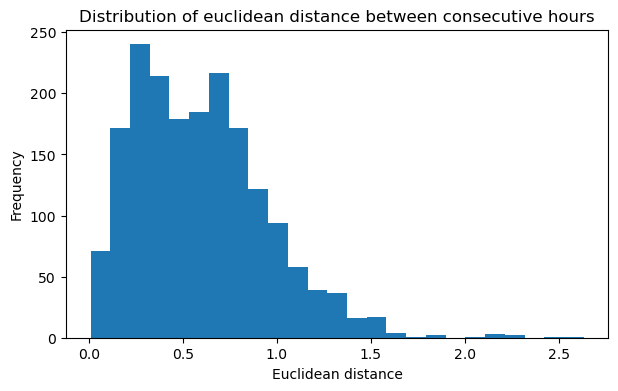

In [ ]:
# Calculate Euclidean distances
euclidean_distances = []
for i in range(len(df_tot_normalized)):
    if i == 0:  # For the first row, compare only to the next
        distance_next = np.linalg.norm(df_tot_normalized[i] - df_tot_normalized[i + 1])
        euclidean_distances.append(distance_next)
    elif i == len(df_tot_normalized) - 1:  # For the last row, compare only to the previous
        distance_prev = np.linalg.norm(df_tot_normalized[i] - df_tot_normalized[i - 1])
        euclidean_distances.append(distance_prev)
    else:  # For all other rows, compare to both previous and next
        distance_prev = np.linalg.norm(df_tot_normalized[i] - df_tot_normalized[i - 1])
        distance_next = np.linalg.norm(df_tot_normalized[i] - df_tot_normalized[i + 1])
        euclidean_distances.append(min(distance_prev, distance_next))

# Add the results to the DataFrame
df_tot['euclidean_distance'] = euclidean_distances

plt.figure(figsize=(7, 4)) 
plt.hist(df_tot['euclidean_distance'], bins=25)
plt.title("Distribution of euclidean distance between consecutive hours")
plt.ylabel("Frequency")
plt.xlabel("Euclidean distance")
plt.show()
